#### Инициализация Keras

torch был заменен на jax, так как с torch рекуррентные сети не работали

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"
import keras

print(keras.__version__)

3.9.2


#### Загрузка данных для классификации с помощью глубоких сетей

В качестве набора данных используется набор отзывов к фильмам с сайта IMDB.

Набор включает 50 000 отзывов, половина из которых находится в обучающем наборе данных (x_train), а половина - в тестовом (x_valid). 

Метки (y_train и y_valid) имеют бинарный характер и назначены в соответствии с этими 10-балльными оценками:
- отзывы с четырьмя звездами или меньше считаются отрицательным (y = 0);
- отзывы с семью звездами или больше считаются положительными (y = 1);
- умеренные отзывы — с пятью или шестью звездами — не включались в набор данных, что упрощает задачу бинарной классификации.

Данные уже предобработаны для простоты работы с ними.

unique_words - в векторное пространство включается только слова, которые встречаются в корпусе не менее 10 000 раз.

max_length - максимальная длина отзыва (если больше, то обрезается, если меньше, то дополняется "пустыми" словами).

In [3]:
from keras.api.datasets import imdb
import os

unique_words = 10000
max_length = 100

output_dir = "tmp"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words=unique_words)

#### Приведение отзывов к длине max_length (100)

padding и truncating - дополнение и обрезка отзывов начинается с начала (учитывается специфика затухания градиента в рекуррентных сетях)

In [4]:
from keras.api.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=max_length, padding="pre", truncating="pre", value=0)
X_valid = pad_sequences(X_valid, maxlen=max_length, padding="pre", truncating="pre", value=0)

#### Формирование архитектуры глубокой многослойной рекуррентной двунаправленной LSTM сети

Параметр return_sequences=True первого рекуррентного слоя позволяет представить вывод этого слоя в формате, подходящем для передачи во второй рекуррентный слой

Первый слой (Embedding) выполняет векторизацию

In [5]:
from keras.api.models import Sequential
from keras.api.layers import InputLayer, Embedding, SpatialDropout1D, LSTM, Bidirectional, Dense

mlstm_model = Sequential()
mlstm_model.add(InputLayer(shape=(max_length,), dtype="float32"))
mlstm_model.add(Embedding(unique_words, 64))
mlstm_model.add(SpatialDropout1D(0.2))
mlstm_model.add(Bidirectional(LSTM(64, dropout=0.2, return_sequences=True)))
mlstm_model.add(Bidirectional(LSTM(64, dropout=0.2)))
mlstm_model.add(Dense(1, activation="sigmoid"))

mlstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 804,993 (3.07 MB)

 Trainable params: 804,993 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

#### Обучение модели

Веса модели сохраняются в каталог tmp после каждой эпохи обучения с помощью callback-параметра

В дальнейшем веса можно загрузить

In [6]:
from keras.api.callbacks import ModelCheckpoint

mlstm_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

mlstm_model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=4,
    validation_data=(X_valid, y_valid),
    callbacks=[ModelCheckpoint(filepath=output_dir + "/mlstm_weights.{epoch:02d}.keras")],
)

Epoch 1/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 65s 329ms/step - accuracy: 0.6714 - loss: 0.5539 - val_accuracy: 0.8469 - val_loss: 0.3582
Epoch 2/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 79s 403ms/step - accuracy: 0.8938 - loss: 0.2680 - val_accuracy: 0.8510 - val_loss: 0.3457
Epoch 3/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 85s 437ms/step - accuracy: 0.9221 - loss: 0.2047 - val_accuracy: 0.8436 - val_loss: 0.3869
Epoch 4/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 97s 496ms/step - accuracy: 0.9459 - loss: 0.1525 - val_accuracy: 0.8372 - val_loss: 0.4265


#### Загрузка лучшей модели и оценка ее качества

Качество модели - 85.1 %.

In [7]:
mlstm_model.load_weights(output_dir + "/mlstm_weights.02.keras")
mlstm_model.evaluate(X_valid, y_valid)

782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.8513 - loss: 0.3512


[0.3456658124923706, 0.8509600162506104]

#### Визуализация распределения вероятностей результатов модели на валидационной выборке

782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step


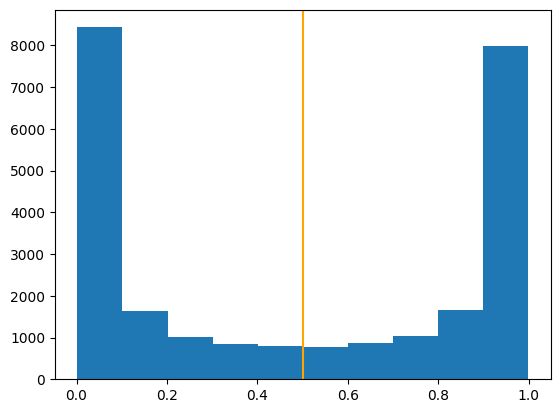

In [8]:
import matplotlib.pyplot as plt

plt.hist(mlstm_model.predict(X_valid))
_ = plt.axvline(x=0.5, color="orange")